/var/folders/hk/kt8z304n2n11x6tfqk2bmsmw0000gp/T/ipykernel_17022/1056552294.py:33: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(D.img), origin='lower', cmap='Purples', extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]],vmin=0.,vmax=3.3)


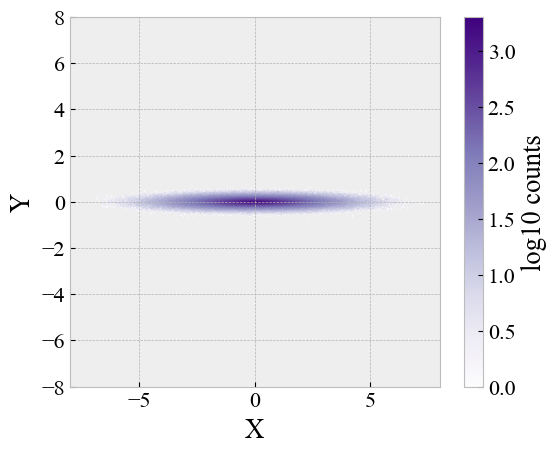

/var/folders/hk/kt8z304n2n11x6tfqk2bmsmw0000gp/T/ipykernel_17022/1056552294.py:47: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(E1.reconstruction), origin='lower', cmap='Purples', extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]],vmin=0.,vmax=3.3)


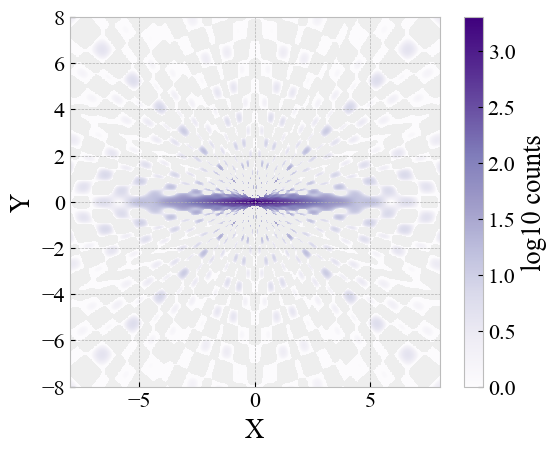

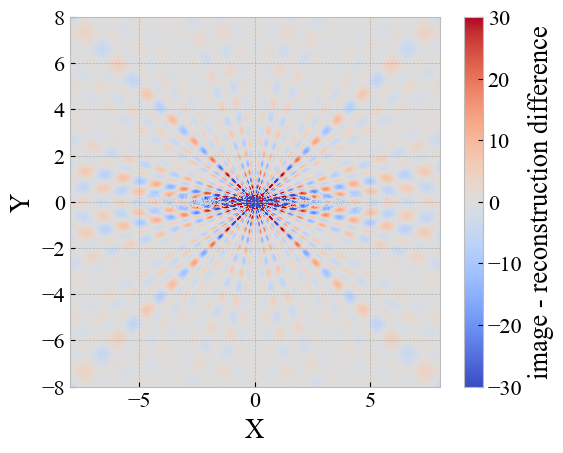

[[ 2.57623458e+02  1.35025531e+02  9.66749841e+01  7.42246602e+01
   5.86603172e+01  4.71939777e+01  3.82865349e+01  3.12714555e+01
   2.57041457e+01  2.12066497e+01]
 [ 5.26952127e-01  5.58521216e-01  5.14368573e-01  4.34569194e-01
   3.33396704e-01  2.23458942e-01  1.13561564e-01  1.01226509e-02
  -8.34854196e-02 -1.67299234e-01]
 [-3.64897496e+02 -1.10441180e+02 -4.24070947e+01 -1.17919826e+01
   3.66728666e+00  1.13037409e+01  1.49451925e+01  1.62106683e+01
   1.60473072e+01  1.51559422e+01]
 [-5.15131191e-01 -5.36057094e-01 -5.34619010e-01 -5.20572121e-01
  -4.86335626e-01 -4.41071518e-01 -3.93358633e-01 -3.50911972e-01
  -3.16462864e-01 -2.85485683e-01]
 [ 2.61341172e+02  2.74988121e+01 -1.86335751e+01 -3.19028558e+01
  -3.46816356e+01 -3.34565358e+01 -3.11501388e+01 -2.86199768e+01
  -2.62145250e+01 -2.41781112e+01]
 [ 8.62017081e-01  8.41128234e-01  7.70152964e-01  6.79638999e-01
   5.69055804e-01  4.61082557e-01  3.73448438e-01  3.19214358e-01
   3.01055170e-01  3.08507805e-01

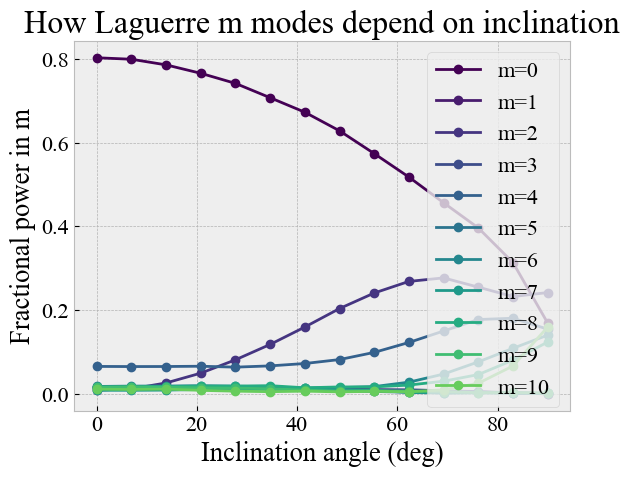

In [12]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import h5py


plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('bmh')

# if DiscModel is in a different file
from src.DiscModel import DiscGalaxy

N = 1000000 # number of stars in the disc
# a is the scale length of the disc in kpc
a = 1.0
D = DiscGalaxy(N=N,a=a)

inclinationvalue = 85.
# no inclination to start (face-on) , in degrees
D.rotate_disc(inclinationvalue,0,0)

# this image is tough to expand (but more realistic)
D.generate_image(rmax=20.,nbins=64,noiselevel=0.5)

# this image is easier to expand (but less realistic): a good starting point
D.generate_image(rmax=8.,nbins=512,noiselevel=0.5)


E = D.make_expansion(10, 10, a)

# Plot the 2D histogram
plt.imshow(np.log10(D.img), origin='lower', cmap='Purples', extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]],vmin=0.,vmax=3.3)
plt.colorbar(label='log10 counts')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# make the FLEX expansion: mmax=10, nmax=10
# this is a good starting point, but you can increase or decrease mmax and nmax to see what happens
E1 = D.make_expansion(50,50,a,noisy=False)

# (re)construct an image from the expansion coefficients
E1.laguerre_reconstruction(D.r,D.p)


plt.imshow(np.log10(E1.reconstruction), origin='lower', cmap='Purples', extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]],vmin=0.,vmax=3.3)
plt.colorbar(label='log10 counts')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

plt.figure()
# why is there a 3%ish bias here?
plt.imshow(D.img - 1.03*E1.reconstruction, origin='lower', cmap='coolwarm', extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]],vmin=-30.,vmax=30.)
plt.colorbar(label='image - reconstruction difference')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


with h5py.File("example_galaxy.hdf5", "a") as f:
    group = f.require_group("f444w/00001_expansion")
    
    # Remove datasets if they exist
    for dname in ["coscoefs", "sincoefs"]:
        if dname in group:
            del group[dname]
    
    # Now safely create
    group.create_dataset("coscoefs", data=E.coscoefs)
    group.create_dataset("sincoefs", data=E.sincoefs)
    group.attrs["inclination_angle_deg"] = inclinationvalue

print(E.coscoefs)
print(E.sincoefs)

import matplotlib.pyplot as plt
import numpy as np
from src.DiscModel import DiscGalaxy

# Parameters
N = 1_000_000
a = 1.0
rmax = 8.
nbins = 512
mmax = 10
nmax = 10

# Inclination angles to test
inclinations = [0, 30, 60, 85]

#prepare figure
#fig, axs = plt.subplots(2, len(inclinations), figsize=(4*len(inclinations), 8))

for idx, inc in enumerate(inclinations):
    # Generate galaxy
    D = DiscGalaxy(N=N, a=a)
    D.rotate_disc(inc, 0, 0)
    D.generate_image(rmax=rmax, nbins=nbins, noiselevel=0.)
    E = D.make_expansion(mmax, nmax, a)
    
    # Compute magnitude of coefficients
    coef_mag = np.sqrt(E.coscoefs**2 + E.sincoefs**2)
    
    # Sum over m to get total power per m
    m_power = np.sum(coef_mag, axis=1)
    
    
    n_power = np.sum(coef_mag, axis=0)
    """
    # Plot
    axs[0, idx].bar(range(mmax+1), m_power)
    axs[0, idx].set_title(f"Inclination {inc}°: Power vs m")
    axs[0, idx].set_xlabel('m')
    axs[0, idx].set_ylabel('Total Power')
    
    axs[1, idx].bar(range(nmax), n_power)
    axs[1, idx].set_title(f"Inclination {inc}°: Power vs n")
    axs[1, idx].set_xlabel('n')
    axs[1, idx].set_ylabel('Total Power')
    """

#plt.tight_layout()
#plt.show()


N = 1_000_000
a = 1.0
rmax = 8.
nbins = 512
mmax = 10
nmax = 10
inclinations = np.linspace(0, 90, 14)  # Inclination angles from 0 to 85 degrees
colormap = plt.cm.viridis(np.linspace(0, 1, len(inclinations)))
# Store results
results = []

for inc in inclinations:
    D = DiscGalaxy(N=N, a=a)
    D.rotate_disc(inc, 0, 0)
    D.generate_image(rmax=rmax, nbins=nbins, noiselevel=0.)
    E = D.make_expansion(mmax, nmax, a)
    
    coef_mag = np.sqrt(E.coscoefs**2 + E.sincoefs**2)
    m_power = np.sum(coef_mag, axis=1)
    total_power = np.sum(m_power)
    frac_power = m_power / total_power
    
    results.append({
        "inclination": inc,
        "m_power": m_power,
        "frac_power": frac_power
    })

# Plot fractional power vs inclination for each m
for m in range(mmax+1):
    plt.plot([r["inclination"] for r in results],
             [r["frac_power"][m] for r in results],
             marker='o', label=f"m={m}", color=colormap[m])

plt.xlabel("Inclination angle (deg)")
plt.ylabel("Fractional power in m")
plt.legend()
plt.title("How Laguerre m modes depend on inclination")
plt.show()


In [1]:
coef_mag

NameError: name 'coef_mag' is not defined

## Test heading